# Прогнозирование оттока пользователей провайдера телекоммуникационных услуг

**Введение:**

Сфера телекоммуникаций — высококонкурентная динамичная среда, в которой уровень осведомленности пользователей позволяет легко получить информацию о других поставщиках услуг с аналогичным или наиболее высоким качеством по более выгодной цене. Отсюда и возникает проблема оттока пользователей.

Для любого провайдера важным аспектом является пользовательская база. В нее поступают новые пользователи, какое-то время активно потребляют услуги и через некоторый промежуток времени перестают, этот промежуток называется «жизненный цикл клиента». Отток пользователей выражается в сокращении пользовательской базы и снижении показателей выручки.


**Цель задачи:**

Создать свое решение по прогнозированию оттока с использованием данных о клиентах. В нашем доступе находится информация о запросах пользователей к сайтам конкурентов и история обращений в компанию.

В качестве метрики выступает Recall по столбцу blocked.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузим-нужные-библиотеки" data-toc-modified-id="Загрузим-нужные-библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузим нужные библиотеки</a></span></li><li><span><a href="#Рассмотрим-датасет-по-ближе" data-toc-modified-id="Рассмотрим-датасет-по-ближе-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Рассмотрим датасет по ближе</a></span><ul class="toc-item"><li><span><a href="#df_train" data-toc-modified-id="df_train-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>df_train</a></span></li><li><span><a href="#df_named" data-toc-modified-id="df_named-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>df_named</a></span></li><li><span><a href="#df_type_contract" data-toc-modified-id="df_type_contract-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>df_type_contract</a></span></li><li><span><a href="#df_log" data-toc-modified-id="df_log-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>df_log</a></span></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Проверка-на-мультиколлинеарность" data-toc-modified-id="Проверка-на-мультиколлинеарность-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Проверка на мультиколлинеарность</a></span></li></ul></li><li><span><a href="#Выделим-выборки" data-toc-modified-id="Выделим-выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выделим выборки</a></span><ul class="toc-item"><li><span><a href="#обучающая-выборка" data-toc-modified-id="обучающая-выборка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>обучающая выборка</a></span></li><li><span><a href="#категоризация-OrdinalEncoder" data-toc-modified-id="категоризация-OrdinalEncoder-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>категоризация OrdinalEncoder</a></span></li><li><span><a href="#тестовая-выборка" data-toc-modified-id="тестовая-выборка-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>тестовая выборка</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Подготовка-результатов" data-toc-modified-id="Подготовка-результатов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка результатов</a></span><ul class="toc-item"><li><span><a href="#предсказание-на-тесте" data-toc-modified-id="предсказание-на-тесте-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>предсказание на тесте</a></span></li><li><span><a href="#запись-в-файл" data-toc-modified-id="запись-в-файл-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>запись в файл</a></span></li></ul></li></ul></div>

## Загрузим нужные библиотеки

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import time
import warnings

from catboost import CatBoostClassifier
from scipy import stats
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 500)

## Рассмотрим датасет по ближе

### df_train

In [4]:
# train — файл содержащий данные пользователей для тренировки. blocked 1 - клиент ушел
df_train = pd.read_csv("datasets/Karelia_train_dataset.csv")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  5992 non-null   int64
 1   blocked      5992 non-null   int64
dtypes: int64(2)
memory usage: 93.8 KB


Посмотрим на распределение целевого признака

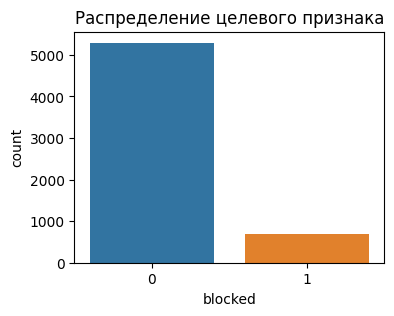

In [6]:
plt.figure(figsize=(4,3))
sns.countplot(x="blocked", data=df_train).set_title('Распределение целевого признака')
plt.show()

### df_named

In [7]:
# df_named - лог днс-запросов к доменам конкурентов (rt.ru и sampo.ru)
df_named = pd.read_csv("datasets/Karelia_named.csv")

In [8]:
df_named.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   date         object
 1   url          object
 2   contract_id  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ MB


In [9]:
df_named.nunique()

date               36
url              6583
contract_id    196148
dtype: int64

In [10]:
df_named.head(3)

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [11]:
#группировка по url
df_named_groupby_url = (
    df_named
    .groupby('url')
    .agg(log_count=('date','count'))
    .sort_values(by='log_count', ascending=False)
    .head(100)
)
df_named_groupby_url

,log_count
url,
camera.rt.ru,7333195
vmxott.svc.iptv.rt.ru,289876
tvip-provision.sampo.ru,138944
webmail.sampo.ru,132718
statserv.sampo.ru,110428
...,...
keyastromgate.rt.ru,5187
643378.16.rt.ru,5134
425128.16.rt.ru,5054


In [12]:
#100 важных url
url_100_imp = df_named_groupby_url.index.to_list()

In [13]:
for url in url_100_imp:
    df_named[url] = (df_named['url']== url)*1

In [14]:
def my_func(col):
    if sum(col) > 0:
        return '1'
    else:
        return '0'

Добавим каждому клиенту бинарных признаков: посещал ли он каждый из ТОП100 по посещаемости сайтов

In [15]:
%%time
df_named_groupby = (
    df_named
    .drop(columns=['date', 'url'])
    .groupby('contract_id').agg(my_func)
)

CPU times: user 4min 50s, sys: 14.1 s, total: 5min 5s
Wall time: 5min 6s


In [16]:
df_named_groupby.shape

(196148, 100)

### df_type_contract

In [17]:
# df_type_contract.csv - тип списания у пользователей. 1 - посуточная
df_type_contract = pd.read_csv("datasets/Karelia_type_contract.csv")

In [18]:
df_type_contract.head()

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0
3,7794,0
4,7795,1


In [19]:
df_type_contract.duplicated().sum()

5

In [20]:
df_type_contract = df_type_contract.drop_duplicates(subset=['contract_id'],ignore_index=True)

In [21]:
df_type_contract.nunique()

contract_id              6800
day_or_month_contract       2
dtype: int64

In [22]:
df_type_contract['day_or_month_contract'].value_counts()

0    4017
1    2783
Name: day_or_month_contract, dtype: int64

### df_log

In [23]:
# log — содержит данные обращения пользователей
df_log = pd.read_csv("datasets/Karelia_log.csv")

In [24]:
df_log.head()

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах


In [25]:
df_log.nunique()

contract_id     4311
event_date     24906
event_type       105
dtype: int64

In [26]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25274 entries, 0 to 25273
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contract_id  25274 non-null  int64 
 1   event_date   25274 non-null  object
 2   event_type   25274 non-null  object
dtypes: int64(1), object(2)
memory usage: 592.5+ KB


In [27]:
df_log['event_type'] = df_log['event_type'].str.lower().str.replace(' ', '_')

In [28]:
for event_type_unique in df_log['event_type'].unique():
    df_log[event_type_unique] = df_log['event_type'].str.contains(event_type_unique)*1

Добавим каждому клиенту бинарных признаков: обращался ли он в службу поддержки с конкретным сообщением

In [29]:
def my_func(col):
    if sum(col) > 0:
        return '1'
    else:
        return '0'

In [30]:
%%time
df_log_groupby = (
    df_log
    .drop(columns=['event_date', 'event_type'])
    .groupby('contract_id').agg(my_func)
)

CPU times: user 3.36 s, sys: 41.4 ms, total: 3.4 s
Wall time: 3.4 s


### Объединение таблиц

Обьединим наборы с данными

In [31]:
df_train = pd.merge(df_train, df_type_contract, on='contract_id', how='left').drop_duplicates(subset='contract_id')
df_train = pd.merge(df_train, df_log_groupby , on='contract_id', how='left')
df_train = pd.merge(df_train, df_named_groupby , on='contract_id', how='left')

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 5991
Columns: 208 entries, contract_id to cm-webapi.rt.ru
dtypes: float64(1), int64(2), object(205)
memory usage: 9.6+ MB


In [33]:
def na_stat(df):
    """
    функция подсчета количества и процента пропущенных значений
    
    """
    df_na_stat = pd.concat([df.isna().sum(), df.isna().mean().map('{:.2%}'.format)], axis=1)
    df_na_stat = df_na_stat[df_na_stat[0] != 0]
    df_na_stat.columns = ['количество пропущенных значений', 'процент пропущенных значений']
    return df_na_stat.sort_values(by='количество пропущенных значений', ascending=False)

In [34]:
na_stat(df_train)

,количество пропущенных значений,процент пропущенных значений
cm-webapi.rt.ru,3077,51.35%
sz-mrsk-itv01.svc.iptv.rt.ru,3077,51.35%
ohrana.sampo.ru,3077,51.35%
vhod.sampo.ru,3077,51.35%
sz-spbr-itv01.svc.iptv.rt.ru,3077,51.35%
...,...,...
просмотр_раздела_тайный_покупатель,2183,36.43%
включение_интернета_на_20_минут_с_ivr,2183,36.43%
турбокнопка_платно_(1_час),2183,36.43%
включение_автоматической_активации_гп,2183,36.43%


In [35]:
# Заменим пропуски на нули
df_train = df_train.fillna('2')
# df_train = df_train.fillna('no_information')

### Проверка на мультиколлинеарность

In [36]:
cat_features = df_train.drop(['contract_id'], axis=1).columns.to_list()
len(cat_features)

207

In [37]:
def cramer_v(df, feature1, feature2, bias_correction=True):
    tab = pd.crosstab(df[feature1], df[feature2])
    chi2 = stats.chi2_contingency(tab)[0]
    n = tab.to_numpy().sum()
    phi2 = chi2 / n
    k, r = tab.shape
    if bias_correction:
        phi2 = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
        k = k - (k - 1)**2 / (n - 1)
        r = r - (r - 1)**2 / (n - 1)
    v = np.sqrt(phi2 / min(k-1, r-1))
    return(v)

def cramer_matrix(df, features, bias_correction=True):
    n = len(features)
    data = np.ones([n, n])
    for i, j in itertools.combinations(range(n), 2):
        data[i, j] = cramer_v(df, features[i], features[j], bias_correction)
        data[j, i] = data[i, j]
    df_cramer = pd.DataFrame(data, index=features, columns=features)
    return df_cramer

In [38]:
%%time
df_cramer = cramer_matrix(df_train, cat_features)

CPU times: user 2min 30s, sys: 5.68 s, total: 2min 36s
Wall time: 2min 36s


In [39]:
df_cramer['blocked'].sort_values(ascending=False)

blocked                                    1.000000
отключение_услуги_аренда_тв-приставки      0.217387
statserv.sampo.ru                          0.199268
kino.sampo.ru                              0.198401
navigator.sampo.ru                         0.198252
                                             ...   
состояние_клиентского_оборудования         0.099196
абонент_оставил_отзыв_в_личном_кабинете    0.099193
тайный_покупатель._отправлена_анкета       0.099190
изменение_контактных_телефонов             0.099190
day_or_month_contract                      0.000000
Name: blocked, Length: 207, dtype: float64

Выделим важные признаки в `cat_features_important`

In [40]:
cat_features_important = df_cramer[df_cramer['blocked'] > 0]['blocked'].index.to_list()
cat_features_important.remove('blocked')
len(cat_features_important)

205

## Выделим выборки

### обучающая выборка

In [41]:
y_train = df_train["blocked"].values.ravel()
X_train = df_train[cat_features_important]
X_train.shape

(5992, 205)

### категоризация OrdinalEncoder

In [42]:
cat_list = ['0','1','2']
categories = []
for i in range(205):
    categories.append(cat_list)

In [43]:
ord_enc = OrdinalEncoder(categories=categories)
X_train[cat_features_important] = ord_enc.fit_transform(X_train[cat_features_important])

### тестовая выборка

In [44]:
df_sample_solution = pd.read_csv("datasets/Karelia_sample_solution.csv")

In [45]:
df_test = df_sample_solution['contract_id']

In [46]:
df_test.shape

(810,)

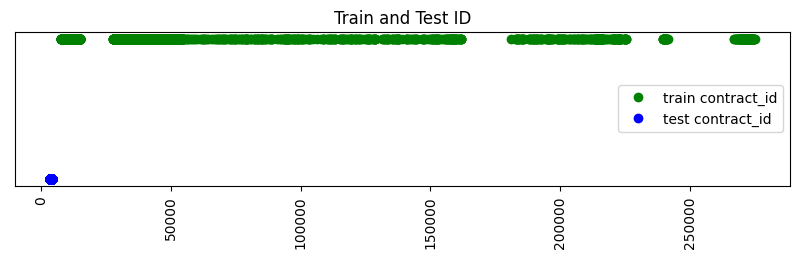

In [47]:
plt.figure(figsize=(10,2))
plt.plot(df_train['contract_id'], np.ones(df_train.shape[0]), 'o', c='green', label='train contract_id')
plt.plot(df_test, np.zeros(df_test.shape[0]), 'o', c='blue', label='test contract_id')
plt.title('Train and Test ID')
plt.yticks([])
plt.xticks(rotation=90)
plt.legend(loc='center right')
plt.show()

In [48]:
#объединение таблиц
df_test = pd.merge(df_test, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id")
df_test = pd.merge(df_test, df_log_groupby , on="contract_id", how='left')
df_test = pd.merge(df_test, df_named_groupby , on="contract_id", how='left')

In [49]:
#заполнение пропусков нулями
df_test = df_test.fillna('2')
# df_test = df_test.fillna('no_information')

In [50]:
# ВАЖНЫЕ признаки
X_test = df_test[cat_features_important]
X_test.shape

(810, 205)

In [51]:
X_test[cat_features_important] = ord_enc.transform(X_test[cat_features_important])

## Обучение моделей

Зафиксируем параметр псевдослучайности для наших моделей и выборок:

In [52]:
rnd_st = 12345

Напишем функцию `grid_search_func` для проведения поиска по решетке, вывода лучших параметров модели и метрики. Функция будет возвращать лучший оценщик

In [53]:
recall = make_scorer(recall_score , average='macro')

In [54]:
def grid_search_func(model, parameters, features_train, target_train):
    """
    model - модель
    param_grid - параметры для поиска по решетке
    features_train - входные признаки обучающая выборка
    target_train - входные признаки тестовая выборка
    
    """
    gs = GridSearchCV(estimator=model, 
                      param_grid=parameters, 
                      scoring=recall, 
                      cv=7, 
                      verbose=0)
    gs.fit(features_train, target_train)
    gs_best_estimator = gs.best_estimator_
    print('Best parameters:', gs.best_params_)
    print('Best recall = %.4f' % abs(gs.best_score_))
    return gs_best_estimator

### CatBoost

In [55]:
cat_pipe = Pipeline([
    ('cl', CatBoostClassifier(verbose=False,
                              loss_function='Logloss', 
                              random_state=rnd_st))
])

parameters = {
    'cl__learning_rate': [0.05, 0.1, 0.15],
    'cl__max_depth': [2],
    'cl__iterations': [200],
    'cl__auto_class_weights': ['Balanced', 'None'],
    'cl__l2_leaf_reg': [1, 3, 5],
}

In [56]:
%%time
cat_best_gs = grid_search_func(cat_pipe, parameters, X_train, y_train)

Best parameters: {'cl__auto_class_weights': 'Balanced', 'cl__iterations': 200, 'cl__l2_leaf_reg': 3, 'cl__learning_rate': 0.1, 'cl__max_depth': 2}
Best recall = 0.6996
CPU times: user 5min 42s, sys: 12.3 s, total: 5min 54s
Wall time: 34.3 s


## Подготовка результатов

### предсказание на тесте

In [57]:
predictions = pd.Series(cat_best_gs.predict(X_test))
predictions.value_counts()

0    596
1    214
dtype: int64

### запись в файл

In [58]:
df_sample_solution['blocked'] = predictions
df_sample_solution.to_csv("datasets/Karelia_sample_solution.csv", index=False)